### 作業目的: 實作word2vec Skip-gram模型
在課程中了解如何搭建CBOW模型，這次的作業目的在於透過搭建Skip-gram模型來了解另外一種word2vec的架構。

Hint_1: 學員可以善用課程中以搭建好的function模組
Hint_2: Skip_gram所需的輸入資料與目標跟CBOW有些許不同，Skip_gram是由中間字詞預測上下文

In [3]:
!unzip Day13-作業檔.zip

Archive:  Day13-作業檔.zip
  inflating: utils/__init__.py       
  inflating: 實作簡易word2vec模型_作業.ipynb  
  inflating: utils/utility.py        
  inflating: utils/optimizer.py      
  inflating: utils/layers.py         
  inflating: utils/__pycache__/utility.cpython-37.pyc  
  inflating: utils/__pycache__/__init__.cpython-37.pyc  
  inflating: utils/__pycache__/optimizer.cpython-37.pyc  
  inflating: utils/__pycache__/layers.cpython-37.pyc  


In [4]:
# import modules
import numpy as np
from typing import List
from utils.utility import clip_grads, convert_one_hot, preprocess, Trainer
from utils.layers import Dense, SoftmaxWithCrossEntropy
from utils.optimizer import SGD

In [5]:
# use the same corpus as in the lecture
text = "I am studying Natural Language Processing now."

# define create_contexts_target function
def create_contexts_target(corpus: List, window_size: int=1):

    contexts = corpus[window_size:-window_size]
    targets = []

    for idx in range(window_size, len(corpus)-window_size):
        cs = []
        for t in range(-window_size, window_size + 1):
            if t == 0:
                # skip target word itself
                continue
            cs.append(corpus[idx + t])
        targets.append(cs)

    return np.array(contexts), np.array(targets)

# transform corpus to contexts and targets pair
corpus, word2idx, idx2word = preprocess([text])
contexts, targets= create_contexts_target(corpus[0], window_size=1)
contexts, targets

(array([5, 3, 7, 0, 1, 2]), array([[6, 3],
        [5, 7],
        [3, 0],
        [7, 1],
        [0, 2],
        [1, 4]]))

In [6]:
# transform contexts and targets to one-hot encoding
contexts = convert_one_hot(contexts, len(word2idx))
targets = convert_one_hot(targets, len(word2idx))
contexts, targets

(array([[0, 0, 0, 0, 0, 1, 0, 0],
        [0, 0, 0, 1, 0, 0, 0, 0],
        [0, 0, 0, 0, 0, 0, 0, 1],
        [1, 0, 0, 0, 0, 0, 0, 0],
        [0, 1, 0, 0, 0, 0, 0, 0],
        [0, 0, 1, 0, 0, 0, 0, 0]], dtype=int32),
 array([[[0, 0, 0, 0, 0, 0, 1, 0],
         [0, 0, 0, 1, 0, 0, 0, 0]],
 
        [[0, 0, 0, 0, 0, 1, 0, 0],
         [0, 0, 0, 0, 0, 0, 0, 1]],
 
        [[0, 0, 0, 1, 0, 0, 0, 0],
         [1, 0, 0, 0, 0, 0, 0, 0]],
 
        [[0, 0, 0, 0, 0, 0, 0, 1],
         [0, 1, 0, 0, 0, 0, 0, 0]],
 
        [[1, 0, 0, 0, 0, 0, 0, 0],
         [0, 0, 1, 0, 0, 0, 0, 0]],
 
        [[0, 1, 0, 0, 0, 0, 0, 0],
         [0, 0, 0, 0, 1, 0, 0, 0]]], dtype=int32))

In [7]:
# define Skip-gram model
class SkipGram:
    def __init__(self, vocab_size, hidden_size, window_size):
        V, H = vocab_size, hidden_size
        self.window_size = window_size

        # initialize weights
        W_in = 0.01 * np.random.randn(V, H).astype('f')
        W_out = 0.01 * np.random.randn(H, V).astype('f')

        # create layers
        self.in_layer = Dense(W_in)
        self.out_layer = Dense(W_out)
        self.loss_layers = [SoftmaxWithCrossEntropy() for i in range(window_size*2)]
        

        layers = [self.in_layer, self.out_layer]
        self.params, self.grads = [], []
        for layer in layers:
            self.params += layer.params
            self.grads += layer.grads
        
        # word vector matrix
        self.word_vecs = W_in

    def forward(self, contexts, targets):
        h = self.in_layer.forward(contexts)
        s = self.out_layer.forward(h)
        
        loss = sum([self.loss_layers[i].forward(s, targets[:, i]) for i in range(self.window_size*2)])
        return loss

    def backward(self, dout=1):
        
        ds = sum([self.loss_layers[i].backward(dout) for i in range(self.window_size*2)])
        dh = self.out_layer.backward(ds)
        self.in_layer.backward(dh)
        
        return None

In [8]:
# start training

# configurations
window_size = 1
hidden_size = 5
batch_size = 3
max_epoch = 1000

# define model
skip_gram = SkipGram(vocab_size=len(word2idx), hidden_size=hidden_size, window_size=window_size)
sgd_optimizer = SGD()
trainer = Trainer(skip_gram, sgd_optimizer)

# start training
trainer.fit(contexts, targets, max_epoch, batch_size)

 26%|██▋       | 263/1000 [00:00<00:00, 1292.51it/s]

Epoch: 1, Iteration: 1/2, Loss: 4.159087712457941
Epoch: 2, Iteration: 1/2, Loss: 4.158961048410745
Epoch: 3, Iteration: 1/2, Loss: 4.158896111974315
Epoch: 4, Iteration: 1/2, Loss: 4.158755228144379
Epoch: 5, Iteration: 1/2, Loss: 4.158786890706475
Epoch: 6, Iteration: 1/2, Loss: 4.158687537114103
Epoch: 7, Iteration: 1/2, Loss: 4.15859322241483
Epoch: 8, Iteration: 1/2, Loss: 4.158594527982515
Epoch: 9, Iteration: 1/2, Loss: 4.15861734963551
Epoch: 10, Iteration: 1/2, Loss: 4.158429562526825
Epoch: 11, Iteration: 1/2, Loss: 4.158319617702128
Epoch: 12, Iteration: 1/2, Loss: 4.158224632807446
Epoch: 13, Iteration: 1/2, Loss: 4.15828014421502
Epoch: 14, Iteration: 1/2, Loss: 4.158078406676646
Epoch: 15, Iteration: 1/2, Loss: 4.157999173220974
Epoch: 16, Iteration: 1/2, Loss: 4.15791278977859
Epoch: 17, Iteration: 1/2, Loss: 4.157929679216407
Epoch: 18, Iteration: 1/2, Loss: 4.15761169650874
Epoch: 19, Iteration: 1/2, Loss: 4.157709309165799
Epoch: 20, Iteration: 1/2, Loss: 4.1572568066

 52%|█████▏    | 520/1000 [00:00<00:00, 1284.35it/s]

Epoch: 270, Iteration: 1/2, Loss: 1.420266943021627
Epoch: 271, Iteration: 1/2, Loss: 1.419072426911278
Epoch: 272, Iteration: 1/2, Loss: 1.422648241195253
Epoch: 273, Iteration: 1/2, Loss: 1.4164591216632882
Epoch: 274, Iteration: 1/2, Loss: 1.4173763458007742
Epoch: 275, Iteration: 1/2, Loss: 1.4182339773505845
Epoch: 276, Iteration: 1/2, Loss: 1.4212924493776395
Epoch: 277, Iteration: 1/2, Loss: 1.4147050579076808
Epoch: 278, Iteration: 1/2, Loss: 1.4173350816342931
Epoch: 279, Iteration: 1/2, Loss: 1.4172886520156283
Epoch: 280, Iteration: 1/2, Loss: 1.4181898559523054
Epoch: 281, Iteration: 1/2, Loss: 1.4157306069124493
Epoch: 282, Iteration: 1/2, Loss: 1.419600319418393
Epoch: 283, Iteration: 1/2, Loss: 1.4142560198148646
Epoch: 284, Iteration: 1/2, Loss: 1.412998332296091
Epoch: 285, Iteration: 1/2, Loss: 1.4209582535198275
Epoch: 286, Iteration: 1/2, Loss: 1.4108523905616777
Epoch: 287, Iteration: 1/2, Loss: 1.4182580893027186
Epoch: 288, Iteration: 1/2, Loss: 1.416240678590402

 78%|███████▊  | 778/1000 [00:00<00:00, 1283.82it/s]

Epoch: 534, Iteration: 1/2, Loss: 1.3961400609454828
Epoch: 535, Iteration: 1/2, Loss: 1.3950921578367002
Epoch: 536, Iteration: 1/2, Loss: 1.395509223310953
Epoch: 537, Iteration: 1/2, Loss: 1.3955638290287977
Epoch: 538, Iteration: 1/2, Loss: 1.3953465424692735
Epoch: 539, Iteration: 1/2, Loss: 1.3957196429630128
Epoch: 540, Iteration: 1/2, Loss: 1.3955329306743667
Epoch: 541, Iteration: 1/2, Loss: 1.3948446001955266
Epoch: 542, Iteration: 1/2, Loss: 1.3952969000663091
Epoch: 543, Iteration: 1/2, Loss: 1.3958741329031528
Epoch: 544, Iteration: 1/2, Loss: 1.3953881491426658
Epoch: 545, Iteration: 1/2, Loss: 1.3947445730368824
Epoch: 546, Iteration: 1/2, Loss: 1.3947148969287742
Epoch: 547, Iteration: 1/2, Loss: 1.3950785627024906
Epoch: 548, Iteration: 1/2, Loss: 1.3958295187861975
Epoch: 549, Iteration: 1/2, Loss: 1.3950183841282149
Epoch: 550, Iteration: 1/2, Loss: 1.3947642196600964
Epoch: 551, Iteration: 1/2, Loss: 1.3948770700011601
Epoch: 552, Iteration: 1/2, Loss: 1.39559411465

100%|██████████| 1000/1000 [00:00<00:00, 1301.24it/s]

Epoch: 803, Iteration: 1/2, Loss: 1.3909062096158762
Epoch: 804, Iteration: 1/2, Loss: 1.3912186920079215
Epoch: 805, Iteration: 1/2, Loss: 1.3913479781478126
Epoch: 806, Iteration: 1/2, Loss: 1.3916577012201954
Epoch: 807, Iteration: 1/2, Loss: 1.3909839299906286
Epoch: 808, Iteration: 1/2, Loss: 1.3910001371176397
Epoch: 809, Iteration: 1/2, Loss: 1.3916551755063122
Epoch: 810, Iteration: 1/2, Loss: 1.390691358389674
Epoch: 811, Iteration: 1/2, Loss: 1.3919022865397515
Epoch: 812, Iteration: 1/2, Loss: 1.3905596556051059
Epoch: 813, Iteration: 1/2, Loss: 1.3916602093490456
Epoch: 814, Iteration: 1/2, Loss: 1.3911998315128056
Epoch: 815, Iteration: 1/2, Loss: 1.3910441078322342
Epoch: 816, Iteration: 1/2, Loss: 1.3912679153025143
Epoch: 817, Iteration: 1/2, Loss: 1.3907881903917976
Epoch: 818, Iteration: 1/2, Loss: 1.3915518916623562
Epoch: 819, Iteration: 1/2, Loss: 1.3909580386285916
Epoch: 820, Iteration: 1/2, Loss: 1.391324079807606
Epoch: 821, Iteration: 1/2, Loss: 1.391033497501

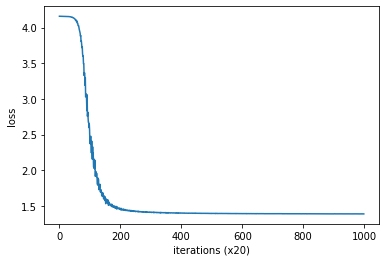

In [9]:
trainer.plot()

In [10]:
# check skip-gram results
word_vecs = skip_gram.word_vecs
for word_id, word in idx2word.items():
    print(word, word_vecs[word_id])

language [-0.05106113  2.4512153   1.7130258   0.80630255 -0.3264761 ]
processing [ 1.2990522  -0.42772326 -0.30719945  0.5715372   2.3915331 ]
now [-0.8901518   0.83300656 -0.4457698   2.1892726  -1.1393089 ]
studying [ 0.3435876   0.38876215  2.3028018  -1.6195451   0.01776959]
. [-0.00133441 -0.00554352  0.00344934  0.01313864 -0.00800242]
am [-0.1552028 -1.4921371 -1.3028235 -1.3275781 -1.58073  ]
i [ 0.00945247  0.01041549  0.00061143 -0.00128906  0.00271757]
natural [-0.78624904 -1.3474741  -2.2295098  -0.45978892  1.430988  ]
